In [22]:
import pickle
import pandas as pd
import scipy as sp
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import Image
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss

# Load data

In [2]:
data_dict = pickle.load(open('quora_questions.pickle', 'rb'))
train = data_dict['train_df']
test = data_dict['test_df']

# Create features

In [5]:
def get_common_tokens_ratio(row):
    if row['all_tokens_count'] == 0:
        return 0
    else:
        return float(row['common_tokens_count']) / float(row['all_tokens_count'])

def count_common_tokens(row, q):
    count = 0
    for token in row['tokens_' + q]:
        if token in row['common_tokens']:
            count += 1
    return count
    
def get_common_tokens_ratio_per_q(row, q):
    if row['token_count_' + q] == 0:
        return 0
    else:
        return float(row['common_tokens_count_' + q]) / float(row['token_count_' + q])

def get_ratio(row, feature):
    count_1 = row[feature + '_question1']
    count_2 = row[feature + '_question2']
    if (count_1 == 0) or (count_2 == 0):
        return 0
    else:
        return float(min(count_1, count_2)) / float(max(count_1, count_2))

In [17]:
df_list = [train, test]
for i in range(len(df_list)):
    df = df_list[i]
    df['all_tokens'] = df.apply(lambda row: set(row['tokens_question1'] + row['tokens_question2']), axis=1)
    df['all_tokens_count'] = df['all_tokens'].apply(len)
    df['common_tokens'] = df.apply(lambda row: set(row['tokens_question1']).intersection(set(row['tokens_question2'])), axis=1)
    df['common_tokens_count'] = df['common_tokens'].apply(len)
    df['common_tokens_ratio'] = df.apply(get_common_tokens_ratio, axis=1)
    
    for q in ['question1', 'question2']:
        df.loc[pd.isnull(df[q]), q] = ''
        df['char_count_' + q] = df[q].apply(len)
        df['token_count_' + q] = df['tokens_' + q].apply(len)
        df['common_tokens_count_' + q] = df.apply(lambda row: count_common_tokens(row, q), axis=1)
        df['common_tokens_ratio_' + q] = df.apply(lambda row: get_common_tokens_ratio_per_q(row, q), axis=1)
    
    for feature in ['char_count', 'token_count']:
        df['ratio_' + feature] = df.apply(lambda row: get_ratio(row, feature), axis=1)

    df_list[i] = df

(train, test) = df_list
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,pair_id,cosine_sim,tokens_question1,tokens_question2,...,char_count_question1,token_count_question1,common_tokens_count_question1,common_tokens_ratio_question1,char_count_question2,token_count_question2,common_tokens_count_question2,common_tokens_ratio_question2,ratio_char_count,ratio_token_count
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0,0.976409,"[What, is, the, step, by, step, guide, to, inv...","[What, is, the, step, by, step, guide, to, inv...",...,66,15,14,0.933333,57,13,13,1.000000,0.863636,0.866667
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,0.716202,"[What, is, the, story, of, Kohinoor, (, Koh-i-...","[What, would, happen, if, the, Indian, governm...",...,51,11,7,0.636364,88,16,8,0.500000,0.579545,0.687500
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,2,0.252362,"[How, can, I, increase, the, speed, of, my, in...","[How, can, Internet, speed, be, increased, by,...",...,73,15,4,0.266667,59,11,4,0.363636,0.808219,0.733333
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,3,0.002819,"[Why, am, I, mentally, very, lonely, ?, How, c...","[Find, the, remainder, when, [, math, ], 23^, ...",...,50,13,2,0.153846,65,19,1,0.052632,0.769231,0.684211
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,4,0.252880,"[Which, one, dissolve, in, water, quikly, suga...","[Which, fish, would, survive, in, salt, water, ?]",...,76,16,5,0.312500,39,8,5,0.625000,0.513158,0.500000


## Save data for future use

In [41]:
import pickle
pickle.dump(train, open('quora_questions_train_features.pickle', 'wb'))
pickle.dump(test, open('quora_questions_test_features.pickle', 'wb'))

# Prep data for training and prediction

In [5]:
features = ['cosine_sim', 'all_tokens_count', 'common_tokens_count', 'common_tokens_ratio', 
            'char_count_question1', 'char_count_question2', 'ratio_char_count', 
            'token_count_question1', 'token_count_question2', 'ratio_token_count', 
            'common_tokens_count_question1', 'common_tokens_count_question2', 
            'common_tokens_ratio_question1', 'common_tokens_ratio_question2']
train_X = train[features]
train_y = train['is_duplicate']
test_X = test[features]

# Log loss function

In [6]:
def logloss(act, pred):
    epsilon = 1e-15
    pred = sp.maximum(epsilon, pred)
    pred = sp.minimum(1-epsilon, pred)
    ll = sum(act*sp.log(pred) + sp.subtract(1,act)*sp.log(sp.subtract(1,pred)))
    ll = ll * -1.0/len(act)
    return ll

# Decision Tree

In [7]:
decision_tree = DecisionTreeClassifier(criterion='entropy') #, min_samples_split=1000)
decision_tree.fit(train_X, train_y)
test_y_decision_tree = decision_tree.predict(test_X)
pred_decision_tree = pd.merge(test, pd.DataFrame(test_y_decision_tree).rename(columns={0: 'is_duplicate'}), left_index=True, right_index=True)
pred_decision_tree[['test_id', 'is_duplicate']].to_csv('submit_3.csv', index=False)
print('log loss on train data:', logloss(train['is_duplicate'], decision_tree.predict(train_X)))

log loss on train data: 0.00914118146511


In [37]:
# 10.97532

# AdaBoost

In [33]:
adaboost = AdaBoostClassifier()
adaboost.fit(train_X, train_y)
test_y_adaboost = adaboost.predict_proba(test_X)[:, 1]
pred_adaboost = pd.merge(test, pd.DataFrame(test_y_adaboost).rename(columns={0: 'is_duplicate'}), left_index=True, right_index=True)
pred_adaboost[['test_id', 'is_duplicate']].to_csv('submit_4.csv', index=False)
print('log loss on train data:', logloss(train['is_duplicate'], adaboost.predict_proba(train_X)[:, 1]))

log loss on train data: 0.655420987094


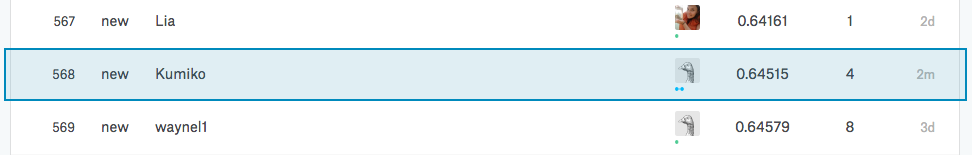

In [36]:
Image(filename='Screen Shot 2017-03-25 at 4.13.17 AM.png')

# Logistic Regression

## Without l2 regularization

In [32]:
logistic_no_l2 = LogisticRegression()
logistic_no_l2.fit(train_X, train_y)
test_y_logistic_no_l2 = logistic_no_l2.predict_proba(test_X)[:, 1]
pred_logistic_no_l2 = pd.merge(test, pd.DataFrame(test_y_logistic_no_l2).rename(columns={0: 'is_duplicate'}), left_index=True, right_index=True)
pred_logistic_no_l2[['test_id', 'is_duplicate']].to_csv('submit_5.csv', index=False)
print('log loss on train data:', logloss(train['is_duplicate'], logistic_no_l2.predict_proba(train_X)[:, 1]))

log loss on train data: 0.540996231645


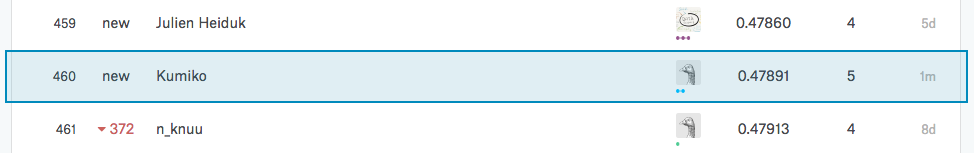

In [37]:
Image(filename='Screen Shot 2017-03-25 at 4.17.28 AM.png')

## With l2 regularization

In [30]:
def find_best_l2(inv_of_l2_list, xscale):
    loss_list = []
    for inv_of_l2 in inv_of_l2_list:
        loss = 0
        model = LogisticRegression(penalty='l2', C=inv_of_l2)
        kf = KFold(n_splits=5, shuffle=True, random_state=0)
        for kf_train_index, kf_test_index in kf.split(train_X):
            kf_train_X, kf_test_X = train_X.ix[kf_train_index], train_X.ix[kf_test_index]
            kf_train_y, kf_test_y = train_y[kf_train_index], train_y[kf_test_index]
            model.fit(kf_train_X, kf_train_y)
            predictions_prob = model.predict_proba(kf_test_X)[:, 1]
            loss += log_loss(kf_test_y, predictions_prob)
            coefficients = model.coef_
            loss += np.sum(coefficients.flatten() ** 2) #l2 norm without square root
        loss = loss / 5.0
        loss_list.append(loss)
    plt.scatter(inv_of_l2_list, loss_list)
    plt.xscale(xscale)
    plt.xlim([min(inv_of_l2_list), max(inv_of_l2_list)])
    plt.ylim([min(loss_list), max(loss_list)])
    plt.xlabel('inverse of l2')
    plt.ylabel('loss')
    best_inv_of_l2 = inv_of_l2_list[loss_list.index(min(loss_list))]
    print('Minimum Loss with Inverse of L2 = %.10f' % best_inv_of_l2)
    return best_inv_of_l2

Minimum Loss with Inverse of L2 = 0.0000020001


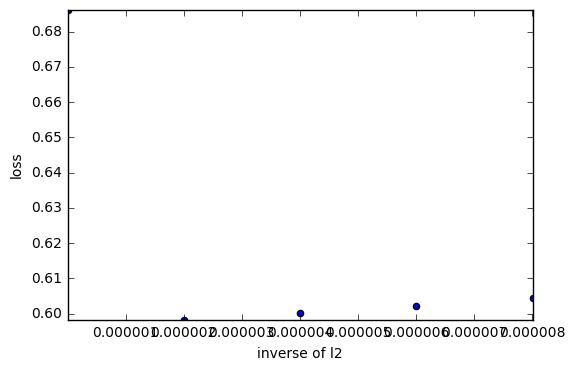

In [31]:
best_inv_of_l2 = find_best_l2(np.arange(1e-10, 1e-5, ((1e-5)-(1e-10))/5), 'linear')

Minimum Loss with Inverse of L2 = 0.0000016000


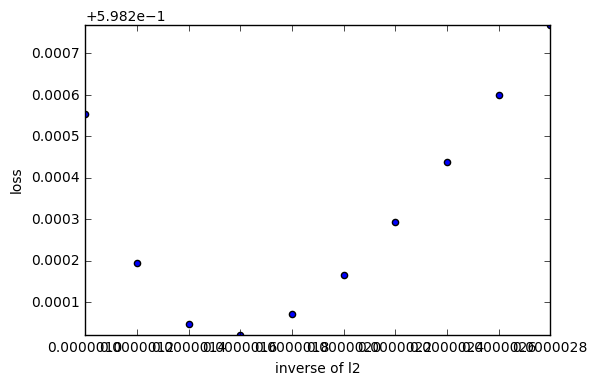

In [32]:
best_inv_of_l2 = find_best_l2(np.arange(0.000001, 0.000003, (0.000003-0.000001)/10), 'linear')

Minimum Loss with Inverse of L2 = 0.0000015400


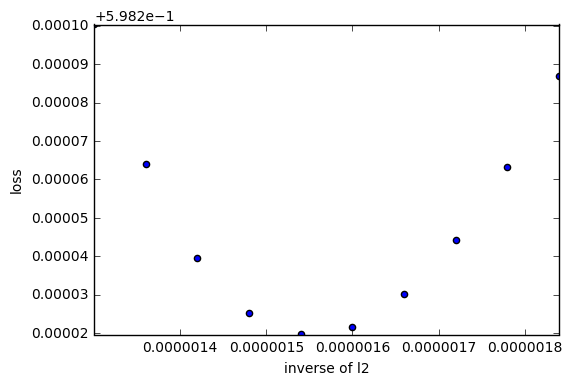

In [33]:
best_inv_of_l2 = find_best_l2(np.arange(0.0000013, 0.0000019, (0.0000019-0.0000013)/10), 'linear')

In [35]:
logistic_l2 = LogisticRegression(penalty='l2', C=best_inv_of_l2)
logistic_l2.fit(train_X, train_y)
test_y_logistic_l2 = logistic_l2.predict_proba(test_X)[:, 1]
pred_logistic_l2 = pd.merge(test, pd.DataFrame(test_y_logistic_l2).rename(columns={0: 'is_duplicate'}), left_index=True, right_index=True)
pred_logistic_l2[['test_id', 'is_duplicate']].to_csv('submit_6.csv', index=False)
print('log loss on train data:', logloss(train['is_duplicate'], logistic_l2.predict_proba(train_X)[:, 1]))

log loss on train data: 0.58779736703


In [36]:
# 0.49644